In [1]:
import os
import torch
import re
import numpy as np
import pandas as pd
from tqdm import tqdm
from PIL import Image
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.models as models
from torchtext.data import get_tokenizer
from torch.nn.utils.rnn import pad_sequence, pack_padded_sequence
from torch.utils.data import DataLoader, Dataset, random_split
import torchvision.transforms as transforms
from torchtext.data.metrics import bleu_score

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
TRAIN_RATIO = 0.85
TEST_RATIO = 0.05
VAL_RATIO = 0.10
PREV_MODEL = '../models/model30k.pth' # None if no previous model

BATCH_SIZE = 32
WORKERS = 4
LEARNING_RATE=0.001
EMBED_SIZE = 324
HIDDEN_SIZE = 640
NUM_LAYERS = 3
EPOCHS = 50


In [4]:
class EncoderCNN(nn.Module):
    def __init__(self, embed_size, train_CNN=False):
        super(EncoderCNN, self).__init__()
        self.train_CNN = train_CNN

        resnet101 = models.resnet101(weights=models.ResNet101_Weights.IMAGENET1K_V2)
        modules = list(resnet101.children())[:-2]
        self.resnet = nn.Sequential(*modules)

        self.adaptive_pool = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Sequential(
            nn.Linear(2048, embed_size),
            nn.ReLU(),
            nn.Dropout(p=0.5)
        )
        self.fine_tune(fine_tune=False)

    def forward(self, images):
        out = self.resnet(images)
        out = self.adaptive_pool(out)
        out = out.view(out.shape[0], -1)
        out = self.fc(out)
        return out
    
    def fine_tune(self, fine_tune=True):

        for p in self.resnet.parameters():
            p.requires_grad = False
        for c in list(self.resnet.children())[7:]:
            for p in c.parameters():
                p.requires_grad = fine_tune




In [5]:
class Attention(nn.Module):
    def __init(self,encoder_dim, decoder_dim, attention_dim):
        super(Attention, self).__init__()
        self.encoder_att = nn.Linear(encoder_dim, attention_dim) 
        self.decoder_att = nn.Linear(decoder_dim, attention_dim) 
        self.full_att = nn.Linear(attention_dim, 1) 
        self.relu = nn.ReLU()
        self.softmax = nn.Softmax(dim=1) 

    def forward(self, encoder_out, decoder_hidden):
        att1 = self.encoder_att(encoder_out)
        att2 = self.decoder_att(decoder_hidden)
        att = self.full_att(self.relu(att1 + att2.unsqueeze(1))).squeeze(2)
        alpha = self.softmax(att)
        attention_weighted_encoding = (encoder_out * alpha.unsqueeze(2)).sum(dim=1)
        return attention_weighted_encoding, alpha


In [6]:
class DecoderRNN(nn.Module):
    def __init__(self, embed_size, hidden_size, vocab_size, num_layers, max_seq_length=40):
        super(DecoderRNN, self).__init__()
        self.embed = nn.Embedding(vocab_size, embed_size)
        self.lstm = nn.LSTM(embed_size, hidden_size, num_layers, batch_first=False)
        self.linear = nn.Linear(hidden_size, vocab_size)
        self.dropout1 = nn.Dropout(0.5)
        self.dropout2 = nn.Dropout(0.3)

    def forward(self, features, captions):
        embeddings = self.dropout1(self.embed(captions))
        # embeddings = self.embed(captions)
        embeddings = torch.cat((features.unsqueeze(0), embeddings), dim=0)
        hiddens, _ = self.lstm(embeddings)
        hiddens = self.dropout2(hiddens)
        outputs = self.linear(hiddens)
        return outputs


In [7]:
class CNNtoRNN(nn.Module):
    def __init__(self, embed_size, hidden_size, vocab_size, num_layers):
        super(CNNtoRNN, self).__init__()
        self.encoderCNN = EncoderCNN(embed_size).to(device)
        self.decoderRNN = DecoderRNN(embed_size, hidden_size, vocab_size, num_layers).to(device)

    def forward(self, images, captions):
        features = self.encoderCNN(images)
        outputs = self.decoderRNN(features, captions)
        return outputs
    
    def caption_image(self, image, vocabulary, max_length=25):
        result_caption = []
        with torch.no_grad():
            x = self.encoderCNN(image).unsqueeze(0) # so that we have a dimention for batch
            states = None
            for _ in range(max_length):
                hiddens, states = self.decoderRNN.lstm(x,states)
                output = self.decoderRNN.linear(hiddens.squeeze(0))
                predicted = output.argmax(1) # take the word with the highest probability

                result_caption.append(predicted.item())
                x = self.decoderRNN.embed(predicted).unsqueeze(0)

                if vocabulary.itos[predicted.item()] == "<EOS>":
                    break
                
        return [vocabulary.itos[idx] for idx in result_caption]
    
    def beam_search(self, image, vocabulary, max_length = 25, beam_width=5):
        image = image.to(device)
        image = image.unsqueeze(0)

        beams = [{"sequence":[vocabulary["<START>"]], "score": 0.0}]

        completed_beams = []

        for _ in range(max_length):
            new_beams = []
            for beam in beams:
                current_sequence = beam["sequence"]
                current_score = beam["score"]

                input_sequence = torch.LongTensor(current_sequence).unsqueeze(1).to(device)

                with torch.no_grad():
                    output = self(image, input_sequence)
                    last_word_probs = output[0, -1, :]

                # Get the top-k next words
                top_k_probs, top_k_indices = torch.topk(last_word_probs, self.beam_width)

                # Expand the beams
                for i in range(self.beam_width):
                    word_index = top_k_indices[i].item()
                    word_prob = top_k_probs[i].item()

                    new_sequence = current_sequence + [word_index]
                    new_score = current_score - torch.log(word_prob)

                    new_beams.append({"sequence": new_sequence, "score": new_score})

            # Sort beams by score and select top-k
            new_beams.sort(key=lambda x: x["score"])
            beams = new_beams[:self.beam_width]

            # Check for completed sequences
            for beam in beams:
                if beam["sequence"][-1] == vocabulary["<END>"]:
                    completed_beams.append(beam)
                    beams.remove(beam)

            if len(beams) == 0:
                break

        # Sort completed beams and return the best one
        completed_beams.sort(key=lambda x: x["score"])
        best_beam = completed_beams[0]
        best_sequence = best_beam["sequence"]

        # Convert the sequence of word indices to words
        caption = [vocabulary.itos[word_index] for word_index in best_sequence[1:-1]]  # Exclude <START> and <END>
        return " ".join(caption)

In [8]:
tokenizer = get_tokenizer("basic_english")

class Vocabulary:
    def __init__(self, freq_threshold):
        self.itos = {0: "<PAD>", 1: "<SOS>", 2: "<EOS>", 3: "<UNK>"}
        self.stoi = {"<PAD>": 0, "<SOS>": 1, "<EOS>": 2, "<UNK>": 3}
        self.freq_threshold = freq_threshold # Minimum frequency for a word to be included in the vocabulary

    def __len__(self):
        return len(self.itos)

    @staticmethod
    def tokenizer_eng(text):
        return [tok.lower() for tok in tokenizer(text)]

    def build_vocabulary(self, sentence_list):
        frequencies = {}
        idx = 4

        for sentence in sentence_list:
            for word in self.tokenizer_eng(sentence):
                if word not in frequencies:
                    frequencies[word] = 1

                else:
                    frequencies[word] += 1

                if frequencies[word] == self.freq_threshold:
                    self.stoi[word] = idx
                    self.itos[idx] = word
                    idx += 1

    def numericalize(self, text):
        tokenized_text = self.tokenizer_eng(text)

        return [
            self.stoi[token] if token in self.stoi else self.stoi["<UNK>"]
            for token in tokenized_text
        ]
    
    def caption_len(self,text):
        tokenized_text = self.tokenizer_eng(text)
        return len(tokenized_text)
    

class FlickrDataset(Dataset):
    def __init__(self, root_dir, captions_file, transform=None, freq_threshold=3):
        self.root_dir = root_dir
        self.df = pd.read_csv(captions_file)
        self.transform = transform

        # Get img, caption columns
        self.imgs = self.df["image"]
        self.captions = self.df["caption"].astype(str)

        # Initialize vocabulary and build vocab
        self.vocab = Vocabulary(freq_threshold)
        self.vocab.build_vocabulary(self.captions.tolist())

    def __len__(self):
        return len(self.df)

    def __getitem__(self, index):
        caption = self.captions[index]
        img_id = self.imgs[index]
        img = Image.open(os.path.join(self.root_dir, img_id)).convert("RGB")

        if self.transform is not None:
            img = self.transform(img)
        caplen = self.vocab.caption_len(caption)
        numericalized_caption = [self.vocab.stoi["<SOS>"]]
        numericalized_caption += self.vocab.numericalize(caption)
        numericalized_caption.append(self.vocab.stoi["<EOS>"])

        return img, torch.tensor(numericalized_caption), torch.LongTensor([caplen])

In [9]:
class SelfCollate:
    def __init__(self, pad_idx):
        self.pad_idx = pad_idx

    def __call__(self, batch):
        imgs = [item[0].unsqueeze(0) for item in batch]
        imgs = torch.cat(imgs, dim=0)
        targets = [item[1] for item in batch]
        targets = pad_sequence(targets, batch_first=False, padding_value=self.pad_idx)

        return imgs, targets

def get_loader(
    root_folder,
    annotation_file,
    transform,
    batch_size=BATCH_SIZE,
    num_workers=WORKERS,
    shuffle=True,
    pin_memory=True,
):
    dataset = FlickrDataset(root_folder, annotation_file, transform=transform)
    total_samples = len(dataset)

    pad_idx = dataset.vocab.stoi["<PAD>"]

    train_size = int(TRAIN_RATIO * total_samples)
    val_size = int(TEST_RATIO * total_samples)
    test_size = total_samples - (train_size + val_size)

    train_set, val_set, test_set = random_split(dataset, [train_size, val_size, test_size])

    train_loader = DataLoader(
        dataset=train_set,
        batch_size=batch_size,
        num_workers=num_workers,
        shuffle=shuffle,
        pin_memory=pin_memory,
        collate_fn=SelfCollate(pad_idx=pad_idx),
    )
    
    val_loader = DataLoader(
        dataset=val_set,
        batch_size=batch_size,
        num_workers=num_workers,
        shuffle=False,
        pin_memory=pin_memory,
        collate_fn=SelfCollate(pad_idx=pad_idx),
    )
    
    test_loader = DataLoader(
        dataset=test_set,
        batch_size=1,
        num_workers=num_workers,
        shuffle=False,
        pin_memory=pin_memory,
        collate_fn=SelfCollate(pad_idx=pad_idx),
    )

    return train_loader, val_loader, test_loader, dataset

In [10]:
# main

transform = transforms.Compose([
        transforms.Resize((326, 326)),
        transforms.RandomCrop((224, 224)), 
        transforms.ToTensor(),
        transforms.Normalize((0.470, 0.456, 0.406), (0.229, 0.224, 0.225))
    ])

train_loader, val_loader, test_loader, dataset = get_loader(
        "../Data/Images/", "../Data/captions30k.txt", transform=transform, num_workers=WORKERS
    )
vocab_size = len(dataset.vocab) # vocabulary size


 Two young , White males are outside near many bushes .


In [11]:
model = CNNtoRNN(embed_size=EMBED_SIZE, hidden_size=HIDDEN_SIZE, vocab_size=vocab_size, num_layers=NUM_LAYERS).to(device)
if PREV_MODEL != None: model.load_state_dict(torch.load(PREV_MODEL, map_location=device), strict=False)

In [12]:
criterion = nn.CrossEntropyLoss(ignore_index=dataset.vocab.stoi['<PAD>']).to(device)
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=EPOCHS, eta_min=0.000000001)


In [13]:
def train(model, train_loader, epochs, criterion, optimizer, scheduler):
    train_loss = []
    validation_loss =[]
    all_bleus = []
    best_bleu = 0.0

    for epoch in range(epochs):
        total_train = 0
        running_train_loss = 0.0
        print(f'Epoch: {epoch +1}')
        model.train()

        for images, captions in tqdm(train_loader, desc="Train\t"):
            images = images.to(device)
            captions = captions.to(device)
           
            optimizer.zero_grad()
            output = model(images, captions[:-1]) 
            loss = criterion(output.reshape(-1, output.shape[2]), captions.reshape(-1))
            loss.backward()
            optimizer.step()
            running_train_loss += loss.item()
            total_train +=  1

        scheduler.step()

        model.eval()
        total_val = 0
        running_val_loss = 0.0
        epoch_bleu = []
        with torch.no_grad():
            for images, captions in tqdm(val_loader, desc="Validate "):
                images = images.to(device)
                captions = captions.to(device)

                v_output = model(images, captions[:-1])
                v_loss = criterion(v_output.reshape(-1, v_output.shape[2]), captions.reshape(-1))
                ref = captions.permute(1,0)
                output_prob = v_output.permute(1,0,2)
                cand = torch.argmax(output_prob, dim=2)
                batch_bleu = []
                for i in range(cand.size(0)):  
                    candidate_sentence = [dataset.vocab.itos[word.item()] for word in cand[i]]
                    reference_sentence = [dataset.vocab.itos[word.item()] for word in ref[i]]
                    bleu = bleu_score([candidate_sentence], [[reference_sentence]], max_n=4, weights=[0.10, 0.25, 0.30, 0.35])
                    batch_bleu.append(bleu)

                running_val_loss += v_loss.item()
                total_val += 1
                epoch_bleu.append(sum(batch_bleu) / len(batch_bleu))

        if epoch_bleu[-1] > best_bleu:
            best_bleu = epoch_bleu[-1]
            torch.save(model.state_dict(), '../models/model4.pth')
        train_loss.append((running_train_loss/total_train))
        validation_loss.append((running_val_loss/total_val))
        all_bleus.append((sum(epoch_bleu) / len(epoch_bleu))* 100)
        print(f'Train Loss: {(running_train_loss/total_train):.4f}, Validation Loss: {(running_val_loss/total_val):.4f}, BLEU Score: {(sum(epoch_bleu) / len(epoch_bleu))* 100:.3f}\n')

    return train_loss, validation_loss, all_bleus


In [14]:
train_loss, val_loss, bleu_score = train(model, train_loader, epochs=EPOCHS, criterion=criterion, optimizer=optimizer, scheduler=scheduler)
print("Training Complete!!")


Epoch: 1


Train	:   0%|          | 0/4222 [00:00<?, ?it/s]

Validate : 100%|██████████| 249/249 [00:18<00:00, 13.49it/s]


Train Loss: 3.8292, Validation Loss: 3.2807, BLEU Score: 1.153

Epoch: 2


Validate : 100%|██████████| 249/249 [00:18<00:00, 13.57it/s]


Train Loss: 3.2089, Validation Loss: 3.0176, BLEU Score: 1.653

Epoch: 3


Validate : 100%|██████████| 249/249 [00:18<00:00, 13.62it/s]


Train Loss: 3.0059, Validation Loss: 2.8876, BLEU Score: 1.964

Epoch: 4


Train	:   7%|▋         | 305/4222 [00:16<03:31, 18.51it/s]


KeyboardInterrupt: 

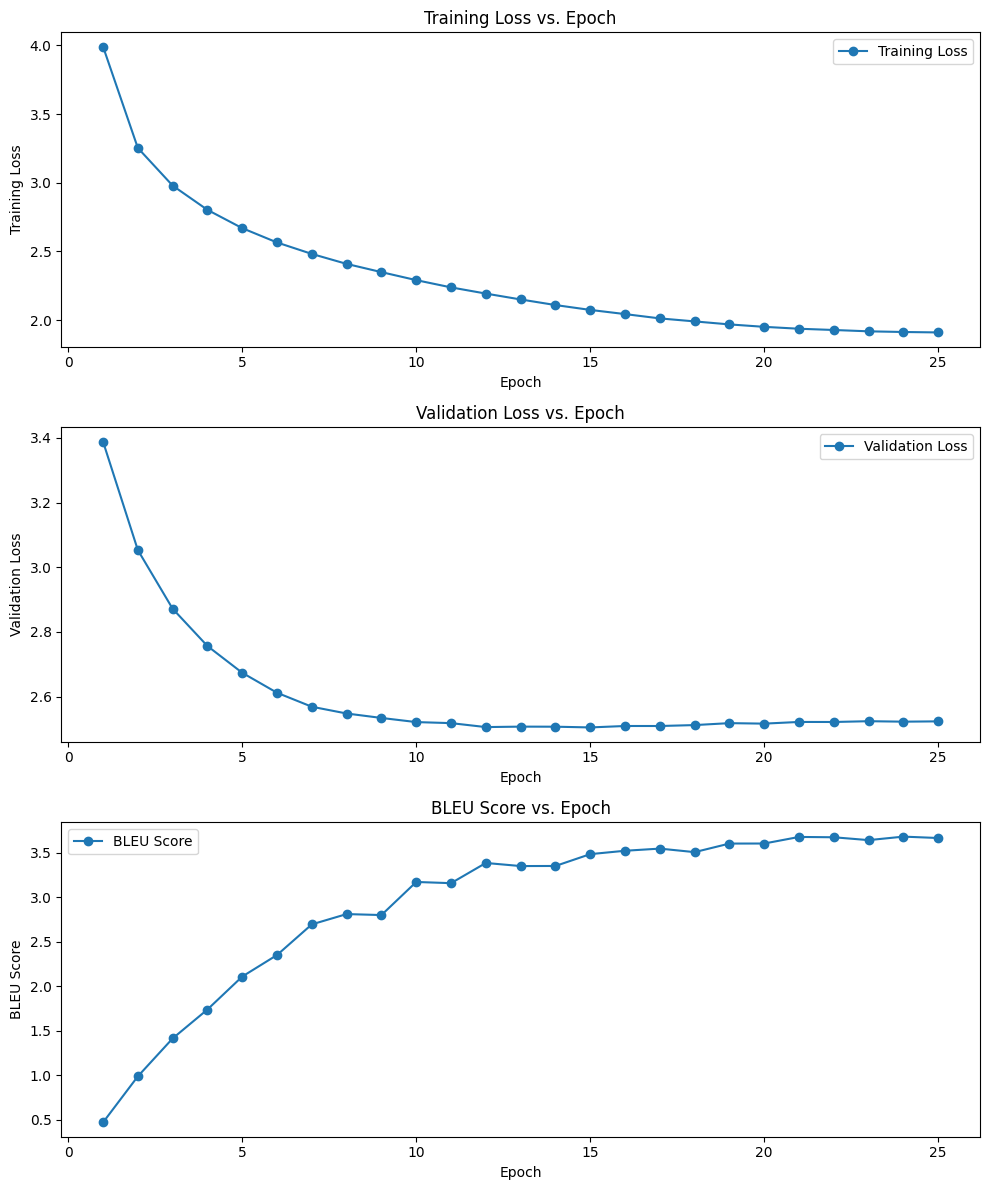

In [ ]:
def plot_losses_and_bleus(train_loss, validation_loss, all_bleus):
    # Create an array of epoch numbers based on the length of the lists
    epochs = list(range(1, len(train_loss) + 1))

    # Create subplots for train loss, validation loss, and BLEU scores
    fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(10, 12))

    # Plot training loss
    ax1.plot(epochs, train_loss, label='Training Loss', marker='o', linestyle='-')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Training Loss')
    ax1.set_title('Training Loss vs. Epoch')
    ax1.legend()

    # Plot validation loss
    ax2.plot(epochs, validation_loss, label='Validation Loss', marker='o', linestyle='-')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Validation Loss')
    ax2.set_title('Validation Loss vs. Epoch')
    ax2.legend()

    # Plot BLEU scores
    ax3.plot(epochs, all_bleus, label='BLEU Score', marker='o', linestyle='-')
    ax3.set_xlabel('Epoch')
    ax3.set_ylabel('BLEU Score')
    ax3.set_title('BLEU Score vs. Epoch')
    ax3.legend()

    plt.tight_layout()
    plt.show()

plot_losses_and_bleus(train_loss, val_loss, bleu_score)

Target: a woman holds an infant baby on a back porch .
Pred: a woman in a blue shirt and a woman in a black shirt are sitting on a bench .

Target: a young woman in a spring coat and purple gloves stands in falling snow .
Pred: a woman in a black shirt and a woman in a black shirt are walking down a street .

Target: one man in a black jacket and black hat is playing a trumpet .
Pred: a man in a black shirt and a woman in a black shirt are playing a guitar .

Target: a person shopping at an open air market in another country .
Pred: a man in a white shirt is standing in front of a store .

Target: three people , one in a red jacket , one in a green jacket , and one in a black jacket , have their jacket hoods over their heads and are standing near the edge of a cliff .
Pred: a man in a blue shirt and a woman in a blue shirt are walking down a beach .

Target: a large gathering of people .
Pred: a group of people are standing in a circle .

Target: a toddler , dressed in white , is inten

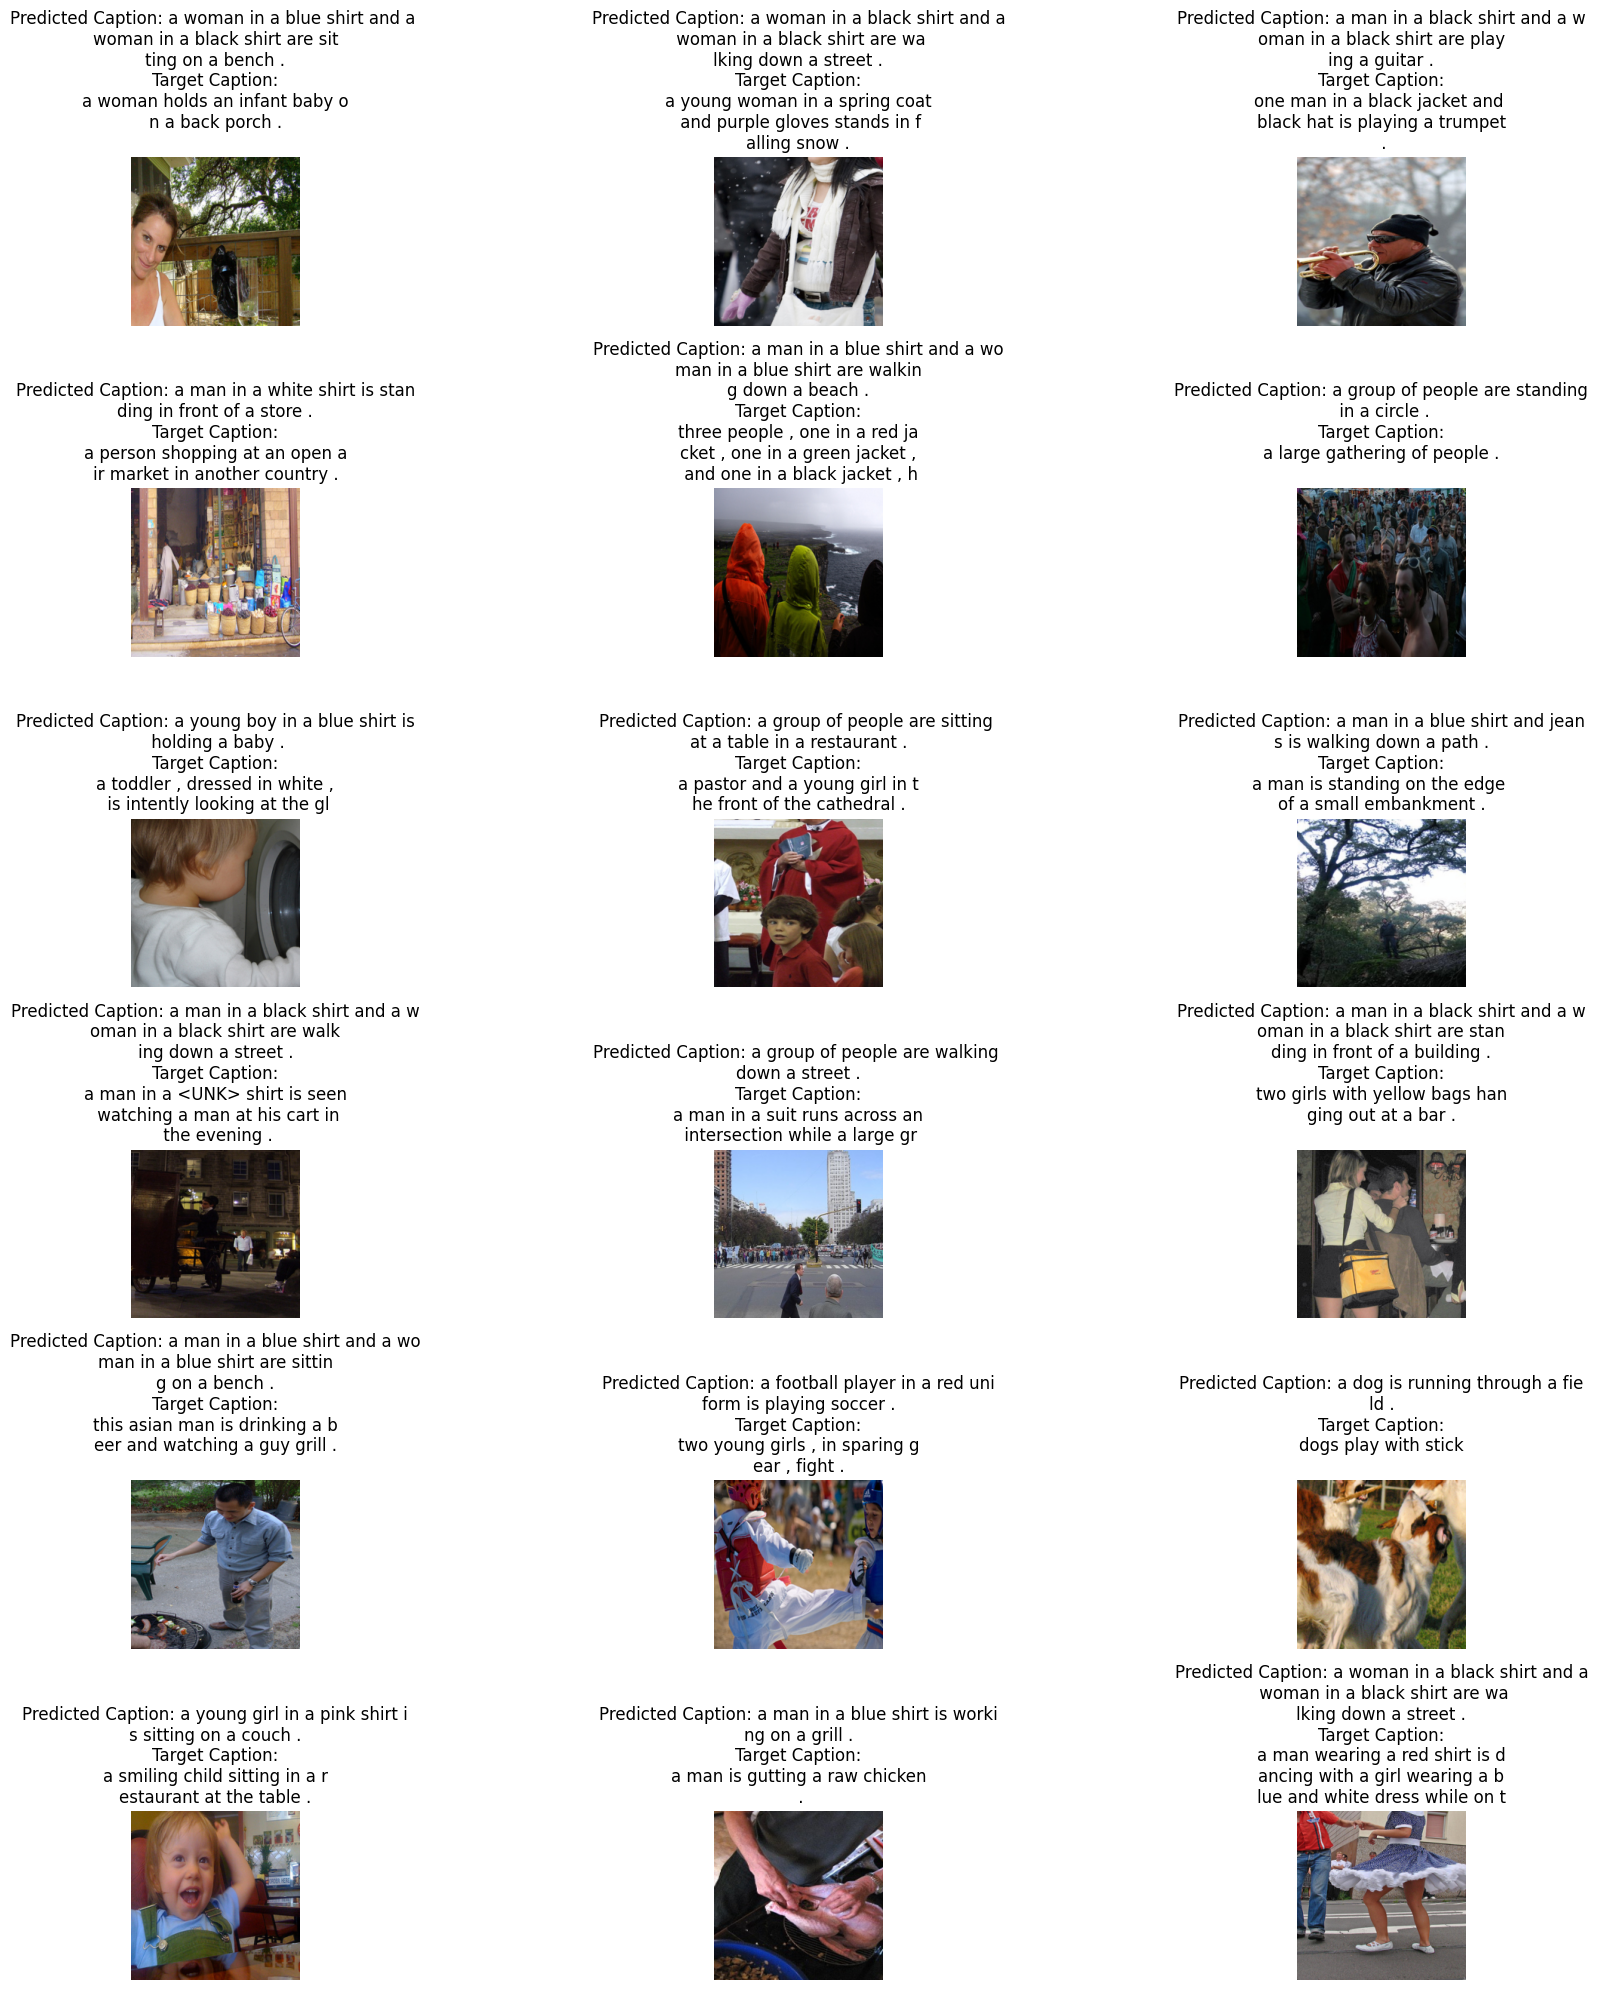

In [15]:
def denormalize(image):

    image = image.squeeze(0).permute(1, 2, 0)
    image = image.cpu().numpy()
    mean = np.array([0.470, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    mean = mean[ np.newaxis, np.newaxis,:]
    std = std[np.newaxis, np.newaxis, :]
    denormalized_image = (image * std) + mean
    denormalized_image = np.clip(denormalized_image, 0, 1)
    return denormalized_image

def sentencer(tokens):
    in_between = False
    extracted_words = []

    for token in tokens:
        if token == '<SOS>':
            in_between = True
        elif token == '<EOS>':
            break
        elif token != '<PAD>' and in_between:
            extracted_words.append(token)

    return " ".join(extracted_words)

def test():
    model.eval()

    num_images = 18
    num_columns = 3
    fig, axs = plt.subplots(num_images // num_columns, num_columns, figsize=(20, 20))


    for idx, (image, caption) in enumerate(test_loader):
        if idx >= num_images:
            break
        row = idx // num_columns  # Calculate the row index (divided by 2 for 2 columns)
        col = idx % num_columns
        image = image.to(device)
        caption = caption.to(device)
        pred_caption = model.caption_image(image, dataset.vocab)

        caption = caption.squeeze(1)
        caption_sen = [dataset.vocab.itos[word.item()] for word in caption]
        pred_cap_sentence = sentencer(pred_caption)
        target_cap_sentence = sentencer(caption_sen)
        print(f'Target: {target_cap_sentence}')
        print(f'Pred: {pred_cap_sentence}\n')

        image_np = denormalize(image)

        caption_lines = [pred_cap_sentence[j:j + 30] for j in range(0, len(pred_cap_sentence), 30)]
        target_lines = [target_cap_sentence[j:j + 30] for j in range(0, len(pred_cap_sentence), 30)]
        formatted_caption = '\n'.join(caption_lines)
        formatted_target_caption = '\n'.join(target_lines)

        axs[row, col].imshow(image_np)
        axs[row, col].axis('off')
        axs[row, col].set_title(f'Predicted Caption: {formatted_caption}\nTarget Caption:\n{formatted_target_caption}')

    plt.tight_layout()
    plt.show()

test()
    

In [16]:
len(dataset)

158915